In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from data_preprocessing import *
from model import *

In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
x_train = training_data.text.apply(lambda x: preprocess_data(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: preprocess_data(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [5]:
y_train, y_val = label_encoder(y_train, y_val)

In [6]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [7]:
pad_len=100
padding_type='post'
truncating_type='post'

In [8]:
tokenizer, x_train_padded, x_val_padded = tokenizer_and_pad_training(x_train, 
                                                                     x_val, 
                                                                     pad_len, 
                                                                     padding_type, 
                                                                     truncating_type)

In [ ]:
dump(tokenizer, "../tokenizers/DL-tokenizer-100.pk1")

In [9]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [10]:
vocab = tokenizer.word_index

In [11]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/cc.mr.300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

32692
Total time taken:  29.76339408


(51791, 300)

In [12]:
input_dim = embedding_matrix1.shape[0]
embedding_dim = 300
input_len = pad_len
print("Input vocab: ", input_dim)
print("Embedding dimensions: ", embedding_dim)
print("Input sentence dimensions: ", input_len)

Input vocab:  51791
Embedding dimensions:  300
Input sentence dimensions:  100


In [13]:
myCB = myCallbacks(metrics='acc', threshold=0.95)

# Feed-Forward Neural Network Model

In [14]:
myDNN = create_model_DNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix1, 
                         input_len, 
                         trainable=False, 
                         n1=64, n2=32, 
                         kr=l2(0.015))
myDNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15537300  
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 15,558,776
Trainable params: 21,476
Non-trainable params: 15,537,300
_________________________________________________________________


In [15]:
history1 = myDNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val), 
                     callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 10s 8ms/step - loss: 1.3795 - acc: 0.4428 - val_loss: 1.2518 - val_acc: 0.5048
Epoch 2/8
1313/1313 [==============================] - 9s 7ms/step - loss: 1.2235 - acc: 0.4992 - val_loss: 1.2071 - val_acc: 0.5286
Epoch 3/8
1313/1313 [==============================] - 10s 8ms/step - loss: 1.1976 - acc: 0.5096 - val_loss: 1.1855 - val_acc: 0.5132
Epoch 4/8
1313/1313 [==============================] - 13s 10ms/step - loss: 1.1845 - acc: 0.5154 - val_loss: 1.1710 - val_acc: 0.5206
Epoch 5/8
1313/1313 [==============================] - 11s 9ms/step - loss: 1.1697 - acc: 0.5356 - val_loss: 1.1572 - val_acc: 0.5410
Epoch 6/8
1313/1313 [==============================] - 11s 9ms/step - loss: 1.1412 - acc: 0.5718 - val_loss: 1.1531 - val_acc: 0.5500
Epoch 7/8
1313/1313 [==============================] - 11s 8ms/step - loss: 1.1245 - acc: 0.5826 - val_loss: 1.1379 - val_acc: 0.5563
Epoch 8/8
1313/1313 [==============================] - 10s 8ms

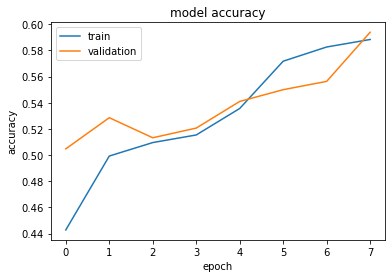

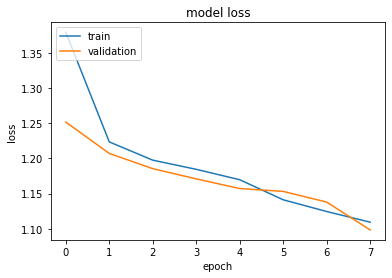

In [16]:
plot_curves(history1)

In [ ]:
name = "FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585"
myDNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myDNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myDNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myDNN = model_load("../models/FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585.h5")

In [17]:
results1 = np.argmax(myDNN.predict(x_val_padded), axis=-1)

In [18]:
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.593915343915344

Precision:  [1.         0.59400179 0.65268456 0.55637513]
Average Precision:  0.7007653714965705

Recall:  [0.00238095 0.88172757 0.43954802 0.5443299 ]
Average nRecall:  0.4669966116594674

F1-Score:  [0.00475059 0.70981546 0.52532073 0.55028661]
Average F1-Score:  0.4475433473370376


# CNN Model

In [19]:
myCNN = create_model_CNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix1, input_len, 
                         trainable=False, 
                         n1=64, k=5, 
                         d=0.25, kr=l2(0.02))
myCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          15537300  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            96064     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 15,633,624
Trainable params: 96,324
Non-trainable params: 15,537,300
_________________________________________________________________


In [20]:
history2 = myCNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val), 
                     callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 50s 38ms/step - loss: 1.2173 - acc: 0.5818 - val_loss: 1.1181 - val_acc: 0.6310
Epoch 2/8
1313/1313 [==============================] - 51s 39ms/step - loss: 1.0967 - acc: 0.6554 - val_loss: 1.0548 - val_acc: 0.6899
Epoch 3/8
1313/1313 [==============================] - 54s 41ms/step - loss: 1.0631 - acc: 0.6779 - val_loss: 1.0254 - val_acc: 0.6907
Epoch 4/8
1313/1313 [==============================] - 58s 44ms/step - loss: 1.0426 - acc: 0.6869 - val_loss: 1.0036 - val_acc: 0.7032
Epoch 5/8
1313/1313 [==============================] - 50s 38ms/step - loss: 1.0307 - acc: 0.6943 - val_loss: 0.9949 - val_acc: 0.6981
Epoch 6/8
1313/1313 [==============================] - 51s 39ms/step - loss: 1.0264 - acc: 0.6991 - val_loss: 0.9961 - val_acc: 0.7222
Epoch 7/8
1313/1313 [==============================] - 55s 42ms/step - loss: 1.0208 - acc: 0.7023 - val_loss: 0.9814 - val_acc: 0.7196
Epoch 8/8
1313/1313 [==============================] - 

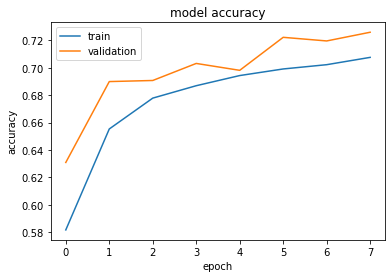

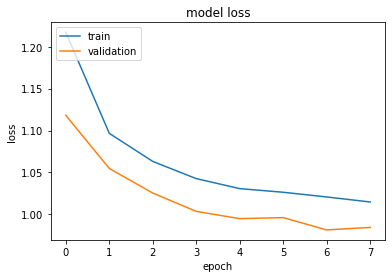

In [21]:
plot_curves(history2)

In [ ]:
name ="CNN/CNN-n1.64n2.64-kr0015-vacc8632"
myCNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myCNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myCNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myCNN = model_load("../models/CNN/CNN-n1.64n2.64-kr0015-vacc8632.h5")

In [22]:
results2 = np.argmax(myCNN.predict(x_val_padded), axis=-1)

In [23]:
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.725925925925926

Precision:  [0.77104377 0.70835639 0.66007905 0.85391566]
Average Precision:  0.7483487192218505

Recall:  [0.5452381  0.85049834 0.75480226 0.58453608]
Average nRecall:  0.68376869411744

F1-Score:  [0.63877266 0.77294686 0.7042699  0.69400245]
Average F1-Score:  0.7024979679007299


# Bi-LSTM Model

In [14]:
myLSTM = create_model_LSTM(input_dim, 
                           embedding_dim, 
                           embedding_matrix1, 
                           input_len, 
                           trainable=False, 
                           n1=32, n2=32, 
                           d=0.3)
myLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15537300  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 64)           85248     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 15,624,760
Trainable params: 87,460
Non-trainable params: 15,537,300
_________________________________________________________________


In [15]:
history3 = myLSTM.fit(x_train_padded, 
                      y_train, 
                      epochs=8, 
                      batch_size=32, 
                      verbose=1, 
                      validation_data = (x_val_padded, y_val), 
                      callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 161s 122ms/step - loss: 0.8231 - acc: 0.6733 - val_loss: 0.6902 - val_acc: 0.7384
Epoch 2/8
1313/1313 [==============================] - 161s 123ms/step - loss: 0.6768 - acc: 0.7386 - val_loss: 0.6451 - val_acc: 0.7545
Epoch 3/8
1313/1313 [==============================] - 167s 127ms/step - loss: 0.6289 - acc: 0.7594 - val_loss: 0.6000 - val_acc: 0.7664
Epoch 4/8
1313/1313 [==============================] - 172s 131ms/step - loss: 0.5973 - acc: 0.7711 - val_loss: 0.5833 - val_acc: 0.7746
Epoch 5/8
1313/1313 [==============================] - 181s 138ms/step - loss: 0.5694 - acc: 0.7802 - val_loss: 0.5566 - val_acc: 0.7862
Epoch 6/8
1313/1313 [==============================] - 190s 145ms/step - loss: 0.5439 - acc: 0.7902 - val_loss: 0.5523 - val_acc: 0.7873
Epoch 7/8
1313/1313 [==============================] - 269s 205ms/step - loss: 0.5262 - acc: 0.7970 - val_loss: 0.5348 - val_acc: 0.7934
Epoch 8/8
1313/1313 [====================

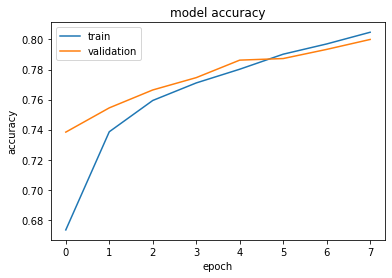

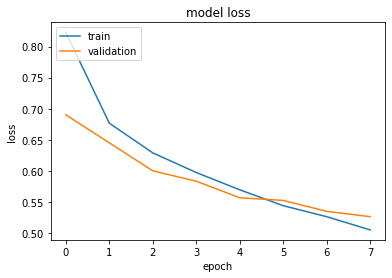

In [16]:
plot_curves(history3)

In [ ]:
name= "LSTM/Bi-LST-n1.64-n2.64-kr0015-vacc868"
myLSTM.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myLSTM.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myLSTM.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myLSTM = model_load("../models/LSTM/Bi-LST-n1.64-n2.64-kr0015-vacc868.h5")

In [17]:
results3 = np.argmax(myLSTM.predict(x_val_padded), axis=-1)

In [18]:
acc, precision, recall, f1 = classification_report(y_val, results3)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8

Precision:  [0.80446927 0.80994898 0.78265642 0.79851538]
Average Precision:  0.7988975128269462

Recall:  [0.68571429 0.84385382 0.80564972 0.77628866]
Average nRecall:  0.7778766209050577

F1-Score:  [0.7403599  0.82655386 0.79398664 0.78724516]
Average F1-Score:  0.7870363887431822
